In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import statsmodels.api as sm
from statsmodels.graphics import regressionplots as rplots
from statsmodels.graphics import gofplots 
from statsmodels.nonparametric.kernel_regression import KernelReg

#from sklearn_xarray import Stacker, Select

In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 
import loess_jtrive
from Linear_Reg_Diagnostic import Linear_Reg_Diagnostic

In [3]:
def standardize(df):
    # anomalies
    andf = df - df.mean()
    # standardized
    std_df = andf/df.std()
    return std_df

## Select and load data

In [70]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)


# load indices

In [95]:
#get sfcT
sfcT_fn = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
sfcT = pd.read_csv(pathcirc+sfcT_fn,header=[0],index_col=[0,1]).loc[:,["sfcT"]]

#get remote indices
#dind_fn1 = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
#dind_fn1 = "diff_memmean_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
dind_fn2 = "diff_custom_indices_sp_avg_allmods_historical_ssp585.csv"
#dind_fn3 = "diff_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv"
#dind_fn3 = "diff_memmean_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv"



preds0 = ["pol","trop","strat"]
preds1 = ["pol","trop","strat","NAWH","Nino4-Nino3"]
preds2 = ["baro","TCWV"]
preds3 = ["NAO","EA","EAWR","SCA"]
dind_df1 = pd.read_csv(pathcirc+dind_fn1,header=[0],index_col=[0,1]).iloc[:,1:]
dind_df2 = pd.read_csv(pathcirc+dind_fn2,header=[0],index_col=[0,1])
dind_df3 = pd.read_csv(pathcirc+dind_fn3,header=[0],index_col=[0,1])

#concat 
dind_df_all = pd.concat([dind_df1,dind_df2,dind_df3],axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lseverino/MT/circulation/diff_memmean_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv'

In [13]:
dind_df_all

pol      trop     strat      NAWH  Nino4-Nino3  \
model         imem                                                        
AWI-CM-1-1-MR 0     7.146866  5.490276 -1.182888  2.809386    -0.263903   
              1          NaN       NaN       NaN       NaN          NaN   
              2          NaN       NaN       NaN       NaN          NaN   
BCC-CSM2-MR   0     6.891896  5.334170 -0.816363  2.460681    -0.111383   
              1          NaN       NaN       NaN       NaN          NaN   
...                      ...       ...       ...       ...          ...   
MPI-ESM1-2-LR 1     5.916541  5.257276  0.494406  2.202200     0.030194   
              2     6.345129  5.102040  0.300191  2.355241     0.111310   
KACE-1-0-G    0    -9.602921  7.230911  1.242553  3.258705    -0.182288   
              1     8.068593  7.317720  0.088979  3.375989    -0.182063   
              2     7.401835  7.191004  0.002456  3.276444    -0.120468   

                        baro      TCWV       NAO        EA      EAWR       SCA  
model         imem                                                              
AWI-CM-1-1-MR 0     0.243631  4.991446  0.152881  3.437205 -0.544412  0.491510  
              1          NaN       NaN       NaN       NaN       NaN       NaN  
              2          NaN       NaN       NaN       NaN       NaN       NaN  
BCC-CSM2-MR   0     0.923933  4.974504  0.273082  3.292483 -0.648636  0.263525  
              1          NaN       NaN       NaN       NaN       NaN       NaN  
...                      ...       ...       ...       ...       ...       ...  
MPI-ESM1-2-LR 1     0.856817  4.480371  0.372667  3.410667 -0.132501  0.262932  
              2     0.525897  4.600256  0.314178  3.007412 -0.257616  0.408893  
KACE-1-0-G    0     1.855826  6.931989  0.612771  4.492766 -0.208132 -0.148585  
              1     1.626519  7.132045  0.564277  4.509497 -0.558158  0.192932  
              2     1.736175  6.830756  0.474178  4.461972 -0.243214  0.254782  

[87 rows x 11 columns]

## Get target values

In [19]:
#select vars
modlist = modlist_ssp585 + modlist_allscen
modset = "allmods"
sel_impf = 'Em2011'
caltype = "AAI_EMDAT_100mn"
proctype = 'diff_qt'
imp_metric = 1

reglist = reglist3
reglist = reglist + ["EU"] #add europe
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmem_max = 3
qt = 0.98
#regaaifn = make_fn(["reg",imp_metric,sel_impf,caltype,modset,futname,pastname],basename=basenamemet_proc,filetype=".csv")
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)

In [20]:
#intiate df to save result
#initiate df to store results
iterrows = [modlist,range(nmem_max)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","imem"])
itercols = [reglist,[pastname,futname]]

col_idx= pd.MultiIndex.from_product(itercols,names=["region","period"])

reg_aai_df = pd.DataFrame(index=row_idx,columns=col_idx)



In [21]:
##construct data arrays for regression stacked
for reg in reglist:
    #loop over the models
    for modid, modname in enumerate(modlist):
    
        simname = 'stacked'
        #read impact data
        if reg == "EU":
            #past
            impfnp= make_fn(['imp',simname,pastname,modname,sel_impf,caltype,proctype],basenamemet_proc,filetype='.csv')
            impp = Impact()
            impp = impp.from_csv(pathimp+"impact csv/aggregated/stacked/"+pastname+"/"+impfnp) 
            
            #future
            impfnf= make_fn(['imp',simname,futname,modname,sel_impf,caltype,proctype],basenamemet_proc,filetype='.csv')
            impf = Impact()
            impf = impf.from_csv(pathimp+"impact csv/aggregated/stacked/"+futname+"/"+impfnf)
        else:
            #past
            impfnp= make_fn(['imp',simname,reg,pastname,modname,sel_impf,caltype,proctype],basenamemet_proc,filetype='.csv')
            impp = Impact()
            impp = impp.from_csv(pathimp+"impact csv/regional/stacked/"+reg+"/"+pastname+"/"+impfnp) 
            
            #future
            impfnf= make_fn(['imp',simname,reg,futname,modname,sel_impf,caltype,proctype],basenamemet_proc,filetype='.csv')
            impf = Impact()
            impf = impf.from_csv(pathimp+"impact csv/regional/stacked/"+reg+"/"+futname+"/"+impfnf)
        
        #get impact metrics
        if imp_metric == 'aai_agg':
            aaip = impp.aai_agg
            aaif = impf.aai_agg
        else:
            aaip = impp.calc_freq_curve(return_per=imp_metric).impact
            aaif = impf.calc_freq_curve(return_per=imp_metric).impact
        
        #write into df
        reg_aai_df.loc[modname,(reg,pastname)] = aaip
        reg_aai_df.loc[modname,(reg,futname)] = aaif
reg_aai_df = reg_aai_df.astype(np.float64)
#reg_aai_df.to_csv(pathcirc+regaaifn)

In [99]:
impfnp= make_fn(['imp',simname,"EEU",pastname,modname,sel_impf,caltype,proctype],basenamemet_proc,filetype='.csv')
impp = Impact()
impp = impp.from_csv(pathimp+"impact csv/regional/stacked/"+"EEU"+"/"+pastname+"/"+impfnp) 

In [22]:
## get model res
#model res df
res_df = pd.DataFrame(columns=["Res"],index=modlist)

for modid, modname in enumerate(modlist):
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    ncdfw = ncdf[[pastname,futname]]
    
    #get resolutiom
    latres, lonres = get_lat_lon_res(ncdfw)
    meanres = np.sqrt(latres**2 + lonres**2)
    res_df.loc[modname,"Res"] = meanres
    res_df.loc[modname] =  meanres
res_df = res_df.astype(np.float64)   

# Multiple Linear Regression

In [79]:
##select data

#models
modlist = modlist_ssp585 + modlist_allscen
#remove outliers
modlist.remove('CNRM-CM6-1-HR')

#modlist.remove('GISS-E2-1-G')
#modlist.remove('MRI-ESM2-0')
#modlist.remove('INM-CM5-0')
#modlist.remove('KACE-1-0-G')
#modlist.remove('MIROC-ES2L')
#modlist.remove('BCC-CSM2-MR')
#modlist.remove('EC-Earth3-Veg')
#modlist.remove('EC-Earth3-Veg-LR')


#impact data
modset = "allmods"
reglist = reglist3+["EU"]
sel_impf = 'Em2011'
caltype = "AAI_EMDAT_100mn"
#imp_metric = "1 yr rp"
pastname = 'historical'
futname = 'ssp585'
timeres='day'
#nmems = 3
#qt = 0.98

#predictors
preds = ["pol","trop","strat","NAWH","Nino4-Nino3"] #predictors
#preds = ["baro","TCWV"] #predictors
#preds = ["NAO","EAWR"]

#regression model
#specify model
normresp = True #normalized by global warming
memmean = True
logresp = False
addTs = False
addres = False



In [80]:
#remove first member of KACE because outlier
dind_df_all_rm = dind_df_all.drop(('KACE-1-0-G',0),axis=0)
reg_aai_df_rm = reg_aai_df.drop(('KACE-1-0-G',0),axis=0)
sfcT_rm = sfcT.drop(('KACE-1-0-G',0),axis=0)

In [81]:
##prepare predictors
#select df
sel_dind_memsep_df = dind_df_all_rm.copy().loc[modlist,preds]
sel_sfcT_memsep = sfcT_rm.loc[modlist]

#memmean 
sel_dind_df = sel_dind_memsep_df.groupby("model").mean()
sel_sfcT = sel_sfcT_memsep.groupby("model").mean()

#normalize by sfcT
sel_dind_df.loc[:,preds] = sel_dind_df.loc[:,preds] / sel_sfcT.values

# anomalies
an_dind_df = sel_dind_df.copy()
an_dind_df = sel_dind_df.loc[:,preds]-sel_dind_df.loc[:,preds].mean()

# standardized
std_an_dind_df = an_dind_df.copy()
std_an_dind_df.loc[:,preds] = an_dind_df/sel_dind_df.std()

In [82]:
#process target var
#memmean
reg_aai_df_ss = reg_aai_df_rm.groupby("model",axis=0).mean()
if logresp:
    reg_aai_df_ss = np.log(reg_aai_df_ss)

In [83]:
## reindex to ensure data alignement
reg_aai_df_ss = reg_aai_df_ss.reindex(modlist)
ind_df = std_an_dind_df.reindex(modlist)
Ts = sel_sfcT.reindex(modlist)

## Ordinary MLR

In [84]:
#mlr for each region using statsmodel
X = ind_df.copy()


X = sm.add_constant(X) # adding a constant
fit_dict = {}
sum_tables = {}
rsq_dict = {} 
rsq_adj_dict = {}
for reg in reglist:
    #select data
    aai_reg = reg_aai_df_ss.loc[:,reg]
    ##diff
    #y = aai_reg.loc[:,futname] - aai_reg.loc[:,pastname]
    
    #ratio
    #y = aai_reg.loc[:,futname] / aai_reg.loc[:,pastname]
    
    #diff ratio
    y = 100*(aai_reg.loc[:,futname]-aai_reg.loc[:,pastname]) / aai_reg.loc[:,pastname]

    if normresp:
        y = y.divide(Ts.values.flatten())
    lm = sm.OLS(y, X) # describe model
    fit = lm.fit() # fit model
    fit_dict[reg] = fit
    sum_tables[reg] = fit.summary()
    
    #compute rsq
    #yfit = fit.fittedvalues
    rsq = comp_rsq(fit,y.values)
    adj_rsq = comp_adj_rsq(fit,y.values,X)
    rsq_dict[reg] = rsq
    rsq_adj_dict[reg] = adj_rsq

    

## Rob MLR

In [85]:
#mlr for each region using statsmodel
X = ind_df.copy()


X = sm.add_constant(X) # adding a constant
fit_dict_rob = {}
sum_tables_rob = {}
rsq_dict_rob = {} 
rsq_adj_dict_rob = {}
for reg in reglist:
    #select data
    aai_reg = reg_aai_df_ss.loc[:,reg]
    ##diff
    #y = aai_reg.loc[:,futname] - aai_reg.loc[:,pastname]
    
    #ratio
    #y = aai_reg.loc[:,futname] / aai_reg.loc[:,pastname]
    
    #diff ratio
    y = 100*(aai_reg.loc[:,futname]-aai_reg.loc[:,pastname]) / aai_reg.loc[:,pastname]

    if normresp:
        y = y.divide(Ts.values.flatten())
    lm = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()) # describe model
    fit = lm.fit() # fit model
    fit_dict_rob[reg] = fit
    sum_tables_rob[reg] = fit.summary()
    
    #compute rsq
    #yfit = fit.fittedvalues
    rsq = comp_rsq(fit,y.values)
    adj_rsq = comp_adj_rsq(fit,y.values,X)
    rsq_dict_rob[reg] = rsq
    rsq_adj_dict_rob[reg] = adj_rsq
    


# Model diagnosis

In [1277]:
## summary tables
sum_tables

{'BI': <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.082
 Model:                            OLS   Adj. R-squared:                 -0.028
 Method:                 Least Squares   F-statistic:                    0.7462
 Date:                Tue, 02 Aug 2022   Prob (F-statistic):              0.535
 Time:                        16:13:20   Log-Likelihood:                -125.95
 No. Observations:                  29   AIC:                             259.9
 Df Residuals:                      25   BIC:                             265.4
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [474]:
sum_tables_rob

{'BI': <class 'statsmodels.iolib.summary.Summary'>
 """
                     Robust linear Model Regression Results                    
 Dep. Variable:                      y   No. Observations:                   29
 Model:                            RLM   Df Residuals:                       24
 Method:                          IRLS   Df Model:                            4
 Norm:                   TukeyBiweight                                         
 Scale Est.:                       mad                                         
 Cov Type:                          H1                                         
 Date:                Mon, 01 Aug 2022                                         
 Time:                        12:35:46                                         
 No. Iterations:                    24                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------------------------------------------

In [86]:
## construct table mlr
row_idx = ["const"]+preds+["Rsq","adj-Rsq"]
sum_df = pd.DataFrame(index=row_idx,columns=reglist)
pval_df = pd.DataFrame(index=["const"]+preds,columns=reglist)

for reg in reglist:
    fitreg = fit_dict[reg]
    #Rsquared
    sum_df.loc["Rsq",reg] = fitreg.rsquared
    sum_df.loc["adj-Rsq",reg] = fitreg.rsquared_adj
    
    #coefs and pvals
    coefs = fitreg.params
    pvals = fitreg.pvalues
    for varname, coef in coefs.items():
        sum_df.loc[varname,reg] = coef
        pval_df.loc[varname,reg] = pvals[varname]
        

In [87]:
## construct table robust mlr
row_idx = ["const"]+preds+["Rsq","adj-Rsq"]
sum_df_rob = pd.DataFrame(index=row_idx,columns=reglist)
pval_df_rob = pd.DataFrame(index=["const"]+preds,columns=reglist)

for reg in reglist:
    fitreg = fit_dict_rob[reg]
    #Rsquared
    sum_df_rob.loc["Rsq",reg] = rsq_dict_rob[reg]
    sum_df_rob.loc["adj-Rsq",reg] = rsq_adj_dict_rob[reg]
    
    #coefs and pvals
    coefs = fitreg.params
    pvals = fitreg.pvalues
    for varname, coef in coefs.items():
        sum_df_rob.loc[varname,reg] = coef
        pval_df_rob.loc[varname,reg] = pvals[varname]

In [88]:
def style_005low(v, props=''):
    return props if v < 0.05 else None
pval_df.index.name = 'p-values'
spval = pval_df.style.applymap(style_005low, props='color:red;')
spval.format('{:.4f}')

,BI,IP,FR,WEU,MED,SC,EEU,EU
p-values,,,,,,,,
const,0.0368,0.0000,0.7376,0.5947,0.0548,0.0049,0.1117,0.2121
pol,0.6429,0.0326,0.1117,0.4180,0.1423,0.0211,0.3282,0.2211
trop,0.5471,0.2076,0.2977,0.3704,0.9896,0.2159,0.2567,0.3033
strat,0.4269,0.0182,0.2201,0.6726,0.0611,0.4089,0.1982,0.1751
NAWH,0.2992,0.0972,0.0545,0.7924,0.0695,0.8586,0.3047,0.1099
Nino4-Nino3,0.8254,0.0126,0.0841,0.6971,0.0426,0.1758,0.1312,0.3438


In [89]:
pval_df_rob.index.name = 'p-values'
spval_rob = pval_df_rob.style.applymap(style_005low, props='color:red;')
spval_rob.format('{:.4f}')

,BI,IP,FR,WEU,MED,SC,EEU,EU
p-values,,,,,,,,
const,0.0832,0.0000,0.6995,0.6456,0.0554,0.0230,0.0813,0.2801
pol,0.5980,0.0510,0.0720,0.3932,0.2766,0.0042,0.4153,0.1800
trop,0.6101,0.1707,0.3417,0.6012,0.8620,0.0479,0.2505,0.4445
strat,0.4760,0.0252,0.4187,0.6975,0.1250,0.7823,0.3161,0.2498
NAWH,0.3577,0.1671,0.0400,0.6889,0.1427,0.6238,0.3856,0.0945
Nino4-Nino3,0.7084,0.0203,0.1960,0.8091,0.0735,0.4847,0.1907,0.5311


In [90]:
sum_df.index.name = 'coefs'

sum_df.style.format('{:.2f}')


,BI,IP,FR,WEU,MED,SC,EEU,EU
coefs,,,,,,,,
const,8.88,-6.12,0.65,1.26,-2.82,5.47,-3.15,2.68
pol,-2.07,-2.16,-3.47,-2.12,-2.33,-4.80,-2.09,-2.89
trop,-2.80,1.28,-2.32,-2.43,-0.02,-2.55,-2.53,-2.51
strat,-4.92,-3.33,-3.65,-1.51,-4.17,-2.24,-3.83,-4.44
NAWH,-4.75,-1.67,-4.32,-0.69,-2.97,0.35,-2.23,-3.88
Nino4-Nino3,1.33,3.47,5.11,1.36,4.45,3.64,4.42,2.99
Rsq,0.08,0.50,0.28,0.06,0.32,0.31,0.15,0.18
adj-Rsq,-0.13,0.38,0.11,-0.16,0.16,0.16,-0.04,-0.01


In [91]:
sum_df_rob.index.name = 'coefs'

sum_df_rob.style.format('{:.2f}')


,BI,IP,FR,WEU,MED,SC,EEU,EU
coefs,,,,,,,,
const,7.40,-6.26,0.78,1.13,-2.91,4.09,-3.45,2.43
pol,-2.48,-2.03,-3.99,-2.31,-1.82,-5.67,-1.78,-3.32
trop,-2.49,1.48,-2.19,-1.47,0.30,-4.07,-2.60,-1.97
strat,-4.63,-3.22,-2.47,-1.45,-3.54,-0.76,-3.02,-3.94
NAWH,-4.40,-1.46,-4.62,-1.10,-2.49,-0.99,-1.92,-4.21
Nino4-Nino3,2.37,3.26,3.86,0.88,4.04,1.87,3.85,2.09
Rsq,0.07,0.50,0.26,0.04,0.31,0.24,0.14,0.17
adj-Rsq,-0.14,0.38,0.10,-0.17,0.16,0.06,-0.05,-0.02


In [92]:
def style_negative(v, props=''):
    return props if v < 0 else None

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def show_significance(s, threshold=0.1):
    if s <= threshold:
        return 'color:{0}; font-weight:bold;textit:--rwrap; textbf:--rwrap;'.format('red')
    else:
        return ''
#s2.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)
#s2 = df2.style.applymap(style_negative, props='color:red;')\
#              .applymap(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)

In [93]:
slice_ = preds
s = sum_df.style.apply(lambda x: pval_df.drop("const",axis=0).applymap(show_significance), axis=None).format('{:.2f}')
s

,BI,IP,FR,WEU,MED,SC,EEU,EU
coefs,,,,,,,,
const,8.88,-6.12,0.65,1.26,-2.82,5.47,-3.15,2.68
pol,-2.07,-2.16,-3.47,-2.12,-2.33,-4.80,-2.09,-2.89
trop,-2.80,1.28,-2.32,-2.43,-0.02,-2.55,-2.53,-2.51
strat,-4.92,-3.33,-3.65,-1.51,-4.17,-2.24,-3.83,-4.44
NAWH,-4.75,-1.67,-4.32,-0.69,-2.97,0.35,-2.23,-3.88
Nino4-Nino3,1.33,3.47,5.11,1.36,4.45,3.64,4.42,2.99
Rsq,0.08,0.50,0.28,0.06,0.32,0.31,0.15,0.18
adj-Rsq,-0.13,0.38,0.11,-0.16,0.16,0.16,-0.04,-0.01


In [94]:
s_rob = sum_df_rob.style.apply(lambda x: pval_df_rob.drop("const",axis=0).applymap(show_significance), axis=None).format('{:.2f}')
s_rob

,BI,IP,FR,WEU,MED,SC,EEU,EU
coefs,,,,,,,,
const,7.40,-6.26,0.78,1.13,-2.91,4.09,-3.45,2.43
pol,-2.48,-2.03,-3.99,-2.31,-1.82,-5.67,-1.78,-3.32
trop,-2.49,1.48,-2.19,-1.47,0.30,-4.07,-2.60,-1.97
strat,-4.63,-3.22,-2.47,-1.45,-3.54,-0.76,-3.02,-3.94
NAWH,-4.40,-1.46,-4.62,-1.10,-2.49,-0.99,-1.92,-4.21
Nino4-Nino3,2.37,3.26,3.86,0.88,4.04,1.87,3.85,2.09
Rsq,0.07,0.50,0.26,0.04,0.31,0.24,0.14,0.17
adj-Rsq,-0.14,0.38,0.10,-0.17,0.16,0.06,-0.05,-0.02


In [656]:
print(s_rob.to_latex())

\begin{tabular}{lllllllll}
 & BI & IP & FR & ME & MD & SC & EA & EU \\
coefs &  &  &  &  &  &  &  &  \\
const & 7.81 & -6.18 & 1.13 & 1.41 & -2.77 & 2.29 & -3.72 & 2.91 \\
pol & -3.44 & \colorred \font-weightbold \textit{\textbf{-1.96}} & \colorred \font-weightbold \textit{\textbf{-4.60}} & -2.66 & -2.02 & \colorred \font-weightbold \textit{\textbf{-5.37}} & -1.53 & -3.69 \\
trop & -1.93 & 1.36 & -1.78 & -1.26 & 0.35 & \colorred \font-weightbold \textit{\textbf{-5.74}} & -2.68 & -1.80 \\
strat & -6.56 & \colorred \font-weightbold \textit{\textbf{-3.43}} & -4.37 & -2.24 & -4.30 & -0.79 & -2.86 & -5.38 \\
NAWH & -3.62 & -1.64 & -3.97 & -0.88 & -2.46 & -2.33 & -1.99 & -3.83 \\
Nino4-Nino3 & 2.56 & \colorred \font-weightbold \textit{\textbf{3.46}} & 4.26 & 0.90 & 4.24 & 3.18 & 3.89 & 2.35 \\
adj-Rsq & -0.12 & 0.36 & 0.11 & -0.15 & 0.10 & 0.50 & -0.07 & 0.04 \\
\end{tabular}



## Variance Inflation Tables

In [56]:
#using Linear_Reg_Diagnostic module
nregs = len(reglist)

for ireg, reg in enumerate(reglist):
    #get linear reg
    fitreg = fit_dict[reg]
    diag = Linear_Reg_Diagnostic(fitreg)
    diag.vif_table()
    

      Features  VIF Factor
0        const        1.00
1          pol        1.17
4         NAWH        1.21
2         trop        1.26
5  Nino4-Nino3        2.13
3        strat        2.23
      Features  VIF Factor
0        const        1.00
1          pol        1.17
4         NAWH        1.21
2         trop        1.26
5  Nino4-Nino3        2.13
3        strat        2.23
      Features  VIF Factor
0        const        1.00
1          pol        1.17
4         NAWH        1.21
2         trop        1.26
5  Nino4-Nino3        2.13
3        strat        2.23
      Features  VIF Factor
0        const        1.00
1          pol        1.17
4         NAWH        1.21
2         trop        1.26
5  Nino4-Nino3        2.13
3        strat        2.23
      Features  VIF Factor
0        const        1.00
1          pol        1.17
4         NAWH        1.21
2         trop        1.26
5  Nino4-Nino3        2.13
3        strat        2.23
      Features  VIF Factor
0        const        1.00
1

## Diagnosis plots


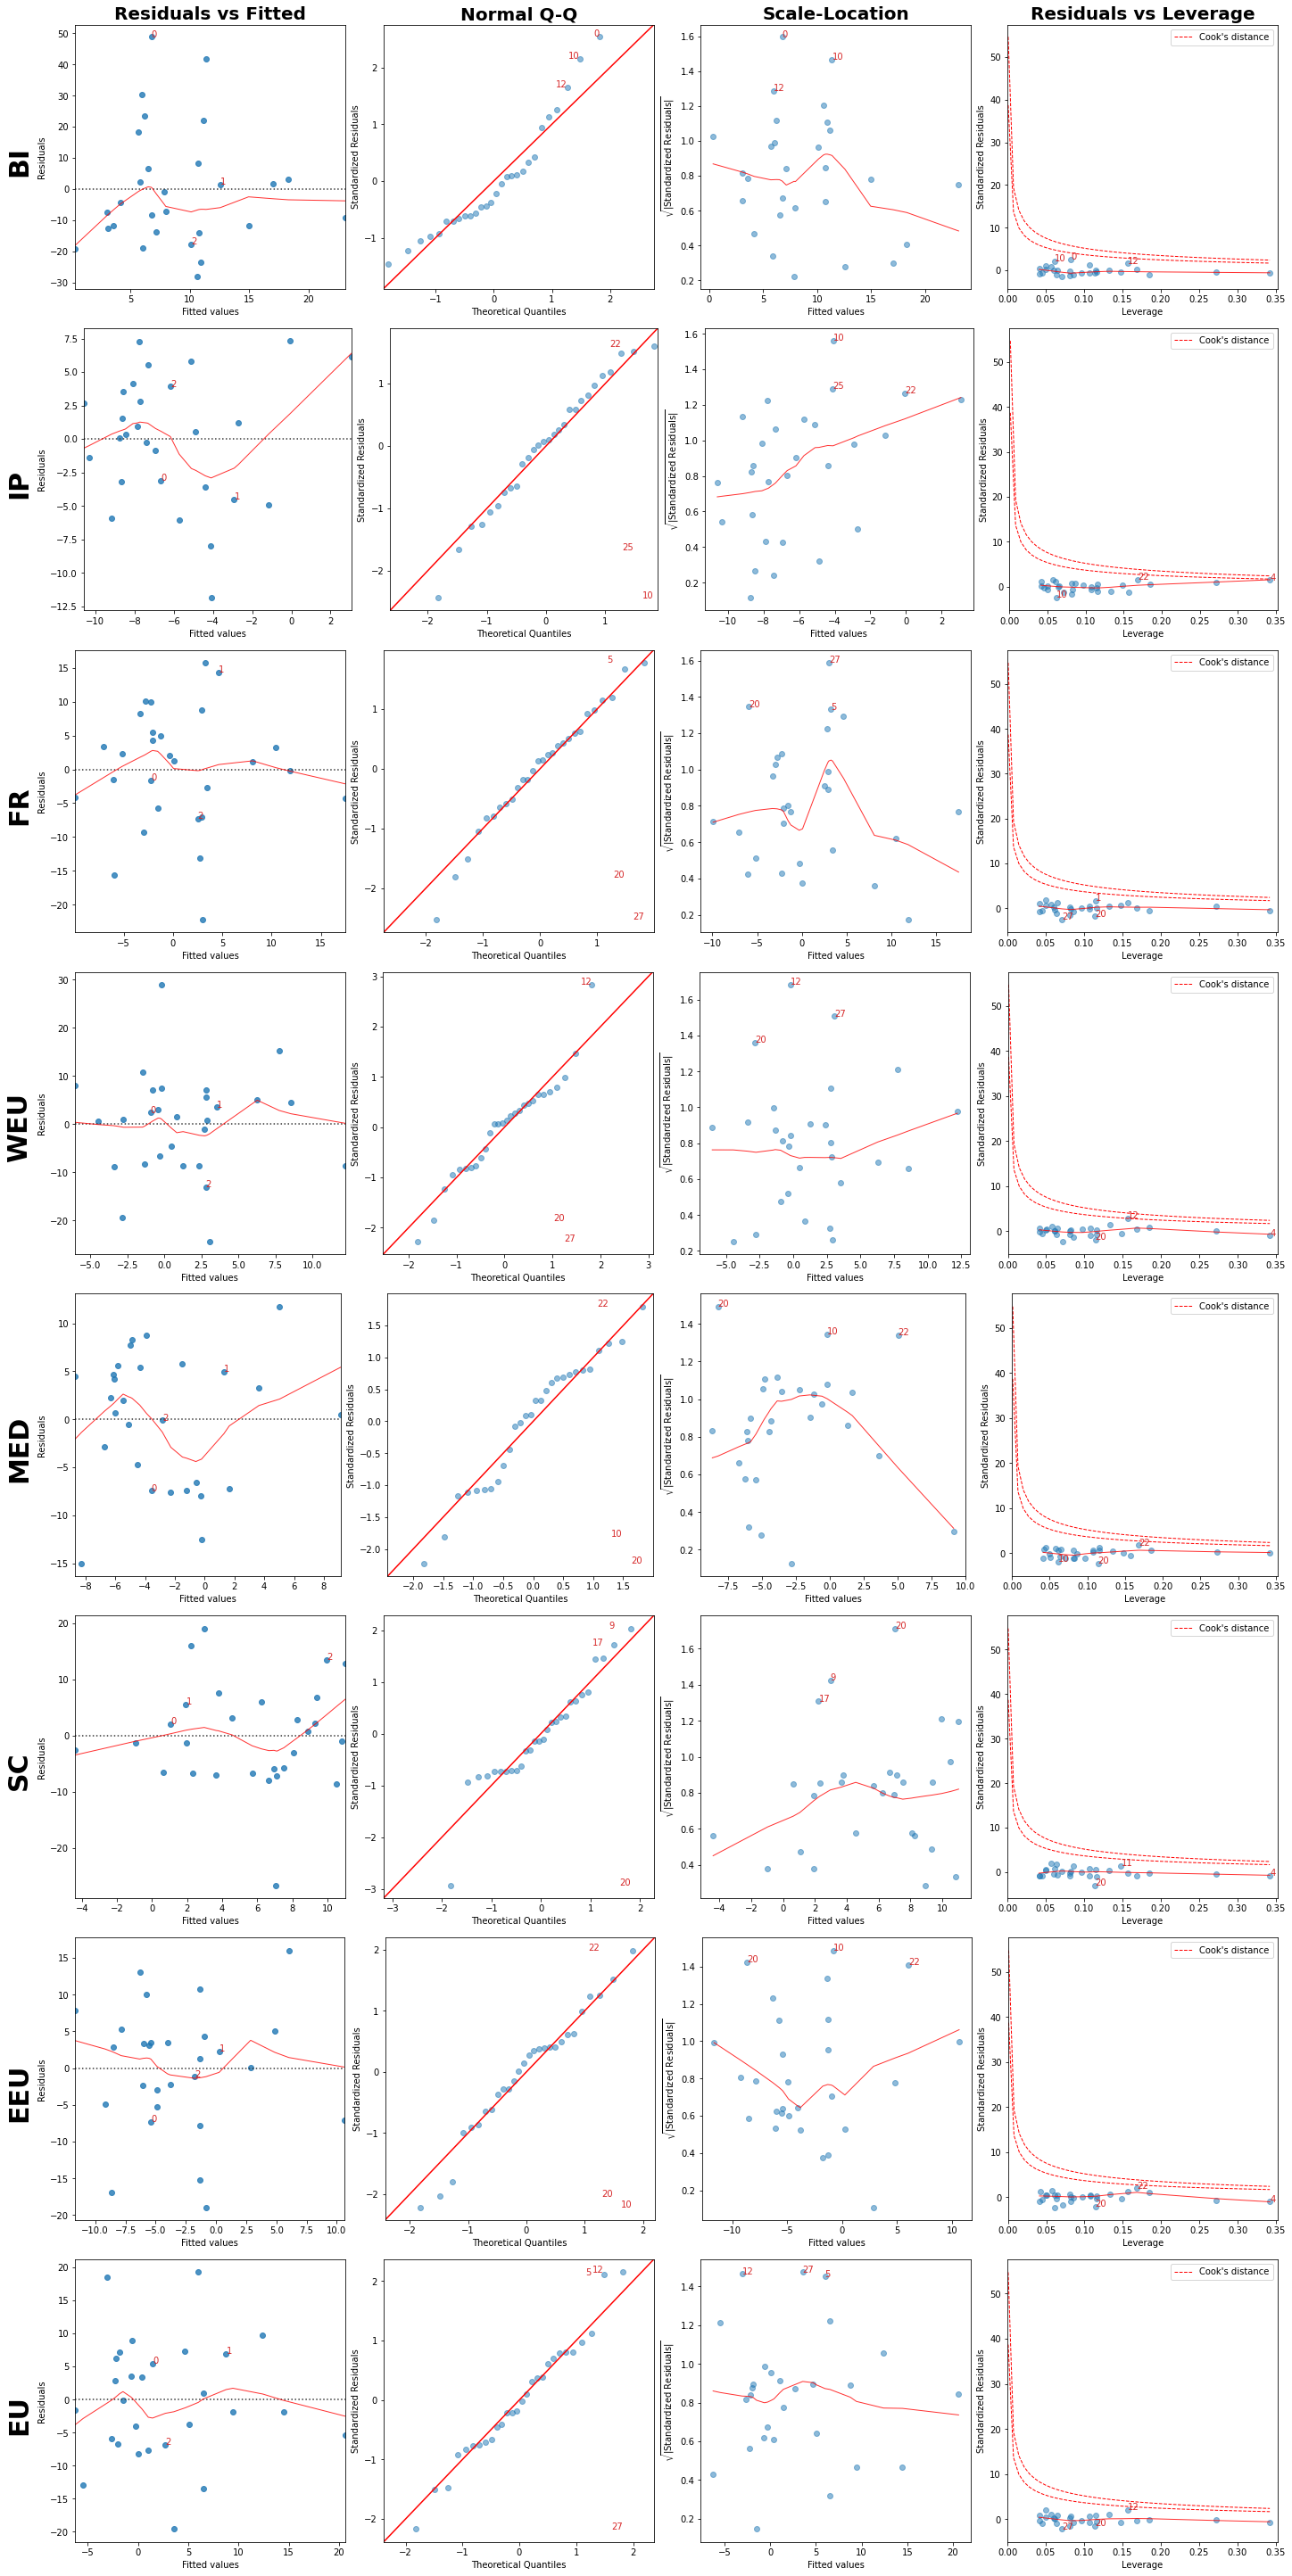

In [73]:
#using Linear_Reg_Diagnostic module
nregs = len(reglist)
nplots = 4
fig = plt.figure(constrained_layout=True,figsize=(5*nplots,5*nregs))
subfigs = fig.subfigures(nrows=nregs, ncols=1)
#axs = fig.subplots(nregs,sharex=False,sharey=False)
for ireg, reg in enumerate(reglist):
    #get linear reg
    fitreg = fit_dict[reg]
    diag = Linear_Reg_Diagnostic(fitreg)
    subfig = subfigs[ireg]
    #get axes
    axs = subfig.subplots(nrows=1, ncols=nplots)
    
    #residual plot
    diag.residual_plot(ax=axs[0],scatter_kws=None)
    
    #qq plot
    diag.qq_plot(ax=axs[1])
    
    #scale loca
    diag.scale_location_plot(ax=axs[2])
    
    #leverage plot
    diag.leverage_plot(ax=axs[3])
    
    if ireg==0:
        [iax.title.set_fontweight('bold') for iax in axs]
        [iax.title.set_fontsize(20) for iax in axs]
    else:
        [iax.set_title('') for iax in axs]
        
    subfig.supylabel(reg,fontsize=30,fontweight="bold")

    

In [74]:
savelocation="results/figures/CircScen/diagplots/"
savefileName = 'diag_plot_NAO_EAWR'
fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

In [494]:
for resreg in fit_dict.values():
    print(resreg.get_influence().cooks_distance[0].max())

0.19728621496672766
0.5209388265405932
0.2570707245731456
0.26636538997893067
0.3055905298078146
0.45157824098089494
0.3443050948638254
0.1810712832749465


## Influence plots

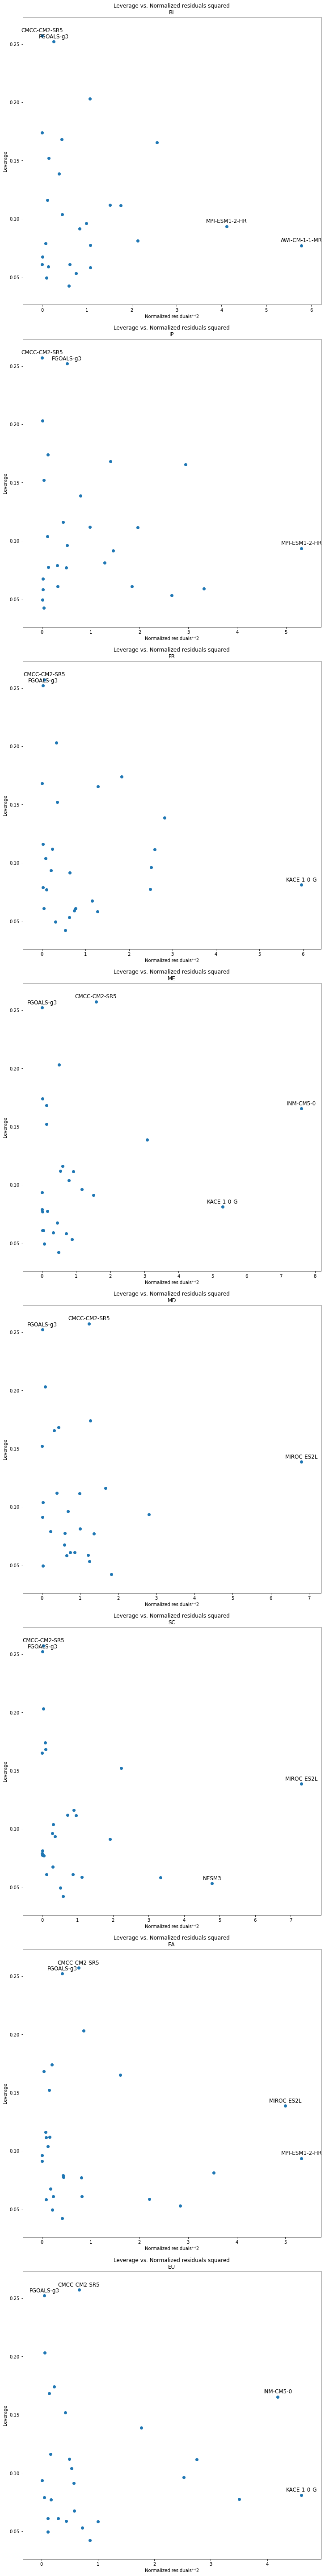

In [375]:
# plots
nregs = len(reglist)
fig = plt.figure(constrained_layout=True,figsize=(10,10*nregs))
axs = fig.subplots(nregs,sharex=False,sharey=False)
for ireg, reg in enumerate(reglist):
    fitreg = fit_dict[reg]
    axi = axs[ireg]
    rplots.plot_leverage_resid2(fitreg,ax=axi)
    axi.set_title("Leverage vs. Normalized residuals squared\n"+reg)

## Variable selection

In [1248]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    y = data[response]
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            #data_sel = data[selected + [candidate].add_constant()
            X = sm.add_constant(data[selected + [candidate]])
            fit = sm.RLM(y.values,X, M=sm.robust.norms.TukeyBiweight()).fit() # describe and fit model
            yfit = fit.fittedvalues
            rsq = comp_rsq(yfit.values,y.values)
            adj_rsq = comp_adj_rsq(yfit.values,y.values,X)
            score = adj_rsq
            #score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    #model = smf.ols(formula, data).fit()
    Xsel = sm.add_constant(data[selected])
    model = sm.RLM(y.values,Xsel, M=sm.robust.norms.TukeyBiweight()).fit() # describe and fit model
    yfit = model.fittedvalues
    rsq = comp_rsq(yfit.values,y.values)
    adj_rsq = comp_adj_rsq(yfit.values,y.values,Xsel)
    best_score = adj_rsq

    return model, best_score

In [1249]:
#mlr for each region using statsmodel
X = ind_df.copy()


#X = sm.add_constant(X) # adding a constant
best_mod_dict = {}
sum_tables_best = {}
rsq_dict_best = {} 
rsq_adj_dict_best = {}
for reg in reglist:
    #select data
    aai_reg = reg_aai_df_ss.loc[:,reg]
    ##diff
    #y = aai_reg.loc[:,futname] - aai_reg.loc[:,pastname]
    
    #ratio
    #y = aai_reg.loc[:,futname] / aai_reg.loc[:,pastname]
    
    #diff ratio
    y = 100*(aai_reg.loc[:,futname]-aai_reg.loc[:,pastname]) / aai_reg.loc[:,pastname]

    if normresp:
        y = y.divide(Ts.values.flatten())
    model_df = pd.concat([y,X],axis=1).astype(np.float64)
    model_df.columns = ['y']+ preds
    model, best_score = forward_selected(model_df, 'y')
    best_mod_dict[reg] = model
    rsq_adj_dict_best[reg] = best_score
    

In [1250]:
rsq_adj_dict_best

{'BI': 0.000781863529352389,
 'IP': 0.35999834063296277,
 'FR': 0.15371939070814478,
 'ME': 3.3582920543340222e-06,
 'MD': 0.06247442243527057,
 'SC': 0.5113919985606519,
 'EA': 0.004149205636900355,
 'EU': 0.12705752562468187}

In [1177]:
best_mod_dict['EU'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                   29
Model:                            RLM   Df Residuals:                       25
Method:                          IRLS   Df Model:                            3
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 02 Aug 2022                                         
Time:                        15:00:09                                         
No. Iterations:                    13                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5872      2.053      1.260      0.208      -1.437       6.611
strat         -3.4223      2.151     -1.591      0.112      -7.638       0.793
pol           -3.5695      2.139     -1.669      0.095      -7.761       0.622
NAWH          -3.4469      2.128     -1.620      0.105      -7.617       0.723
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

## Stepwise regression

In [1251]:
import numpy as np
import warnings
import os
import statsmodels.formula.api as smf
import pandas as pd
import functools
import re
warnings.filterwarnings('ignore')


class stepwise:

    def __init__(self,step,fit_intercept):
        self.step = step
        self.fit_intercept = fit_intercept

    def reduce_concat(self,x, sep=""):
        return functools.reduce(lambda x, y: str(x) + sep + str(y), x)

    def fit(self,data,null_formula,full_formula,response):

        """Linear model designed by forward selection.
        Parameters:
        -----------
        data : pandas DataFrame with all possible predictors and response
        response: string, name of response column in data
        Returns:
        --------
        model: an "optimal" fitted statsmodels linear model
               with an intercept
               selected by forward selection
               evaluated by aic
        """

        null_temp        = re.split('~',null_formula)
        null_predic_com  = null_temp[1].split('+')
        null_predic      = null_predic_com[1:len(null_predic_com)]
        full_temp        = re.split('~',full_formula)
        full_predic_com  = full_temp[1].split('+')
        full_predic      = full_predic_com[1:len(full_predic_com)]
        indices          = [i for i,id in enumerate(full_predic) if id not in null_predic]
        domain           = [full_predic[i] for i in indices]
        start            = set(null_predic)
        remaining        = set(domain)
        selected         = null_predic
        current_score, best_new_score = 0, 0
        score_selected   = []
        variable_added   = []
        y = data[response]
        #selected.remove('')
        while (remaining and current_score == best_new_score and self.step >0):
            scores_with_candidates = []
            for candidate in remaining:
                formula = "{} ~ {}".format(response,' + '.join(selected + [candidate]))
                if self.fit_intercept == 0:
                    formula = formula + "-1"
                X = sm.add_constant(data[selected + [candidate]])
                fit = sm.RLM(y.values,X, M=sm.robust.norms.TukeyBiweight()).fit()
                yfit = fit.fittedvalues
                rsq = comp_rsq(yfit.values,y.values)
                adj_rsq = comp_adj_rsq(yfit.values,y.values,X)
                score = adj_rsq
                #score = -smf.ols(formula, data).fit().rsquared_adj
                scores_with_candidates.append((score, candidate))
            scores_with_candidates.sort()
            best_new_score, best_candidate = scores_with_candidates.pop()
            if current_score < best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                score_selected.append(best_new_score)
                variable_added.append(best_candidate)
                current_score = best_new_score
            self.step=self.step-1
        formula = "{} ~ {}".format(response,' + '.join(selected))
        if self.fit_intercept == 0:
            formula = formula + "-1"
        #model = smf.ols(formula, data).fit()
        
        Xsel = sm.add_constant(data[selected])
        model = sm.RLM(y.values,Xsel, M=sm.robust.norms.TukeyBiweight()).fit() # describe and fit model
        yfit = model.fittedvalues
        rsq = comp_rsq(yfit.values,y.values)
        adj_rsq = comp_adj_rsq(yfit.values,y.values,Xsel)
        best_score = adj_rsq
        return model, best_score, selected

In [1264]:
#mlr for each region using statsmodel
best_mod_dict = {}
sum_tables_best = {}
best_preds_dict = {} 
best_score_dict = {}
X = ind_df.copy()
for reg in reglist:
    #select data
    aai_reg = reg_aai_df_ss.loc[:,reg]
    ##diff
    #y = aai_reg.loc[:,futname] - aai_reg.loc[:,pastname]
    
    #ratio
    #y = aai_reg.loc[:,futname] / aai_reg.loc[:,pastname]
    
    #diff ratio
    y = 100*(aai_reg.loc[:,futname]-aai_reg.loc[:,pastname]) / aai_reg.loc[:,pastname]

    if normresp:
        y = y.divide(Ts.values.flatten())
    model_df = pd.concat([y,X],axis=1).astype(np.float64)
    if 'Nino4-Nino3' in preds:
        preds.remove('Nino4-Nino3')
        preds.append('Nino43')
    
    model_df.columns = ['y']+ preds
    full_form = 'y~1+'+'+'.join(preds)
    null_form = 'y~1'
    best_mod = stepwise(20,True)
    best_mod, best_score, best_preds = best_mod.fit(model_df,null_form,full_form,'y')
    
    best_mod_dict[reg] = best_mod
    best_score_dict[reg] = best_score
    best_preds_dict[reg] = best_preds
    

In [1265]:
best_score_dict

{'BI': 0.000781863529352389,
 'IP': 0.35999834063296277,
 'FR': 0.15371939070814478,
 'ME': 3.3582920543340222e-06,
 'MD': 0.06247442243527057,
 'SC': 0.5113919985606519,
 'EA': 0.004149205636900355,
 'EU': 0.12705752562468187}

In [1266]:
## construct table robust mlr
row_idx = ["const"]+preds+["adj-Rsq"]
best_mod_sum_df_rob = pd.DataFrame(index=row_idx,columns=reglist)
best_mod_pval_df_rob = pd.DataFrame(index=["const"]+preds,columns=reglist)

for reg in reglist:
    fitreg = best_mod_dict[reg]
    #coefs and pvals
    coefs = fitreg.params
    pvals = fitreg.pvalues
    for varname, coef in coefs.items():
        best_mod_sum_df_rob.loc[varname,reg] = coef
        best_mod_pval_df_rob.loc[varname,reg] = pvals[varname]
        
    ##compute rsq and ajd rsq
    #sel_preds = fitreg.model.data.param_names
    #if 'const' in sel_preds:
    #    sel_preds.remove('const')
    #if 'Nino43' in sel_preds:
    #    sel_preds.remove('Nino43')
    #    sel_preds.append('Nino4-Nino3')
    #Xsel = sm.add_constant(X[sel_preds])
    #yfit = fitreg.fittedvalues
    #rsq = comp_rsq(yfit.values,y.values)
    #adj_rsq = comp_adj_rsq(yfit.values,y.values,Xsel)
    
    
    #best_mod_sum_df_rob.loc["Rsq",reg] = rsq
    best_mod_sum_df_rob.loc["adj-Rsq",reg] = best_score_dict[reg]
    

In [1268]:
slice_ = preds
s = best_mod_sum_df_rob.style.apply(lambda x: best_mod_pval_df_rob.drop("const",axis=0).applymap(show_significance), axis=None).format('{:.2f}',na_rep='-')
s

,BI,IP,FR,ME,MD,SC,EA,EU
const,8.71,-6.18,1.27,1.52,-2.44,2.30,-3.39,2.59
pol,-,-1.96,-4.61,-,-,-5.19,-,-3.57
trop,-,1.36,-1.02,-,2.44,-5.54,-,-
strat,-3.70,-3.43,-,-,-,-,-,-3.42
NAWH,-,-1.64,-3.48,-,-,-2.16,-,-3.45
Nino43,-,3.46,-,-,-,2.62,1.93,-
adj-Rsq,0.00,0.36,0.15,0.00,0.06,0.51,0.00,0.13


In [1077]:
print(s.to_latex())

\begin{tabular}{lllllllll}
 & BI & IP & FR & ME & MD & SC & EA & EU \\
const & 7.53 & -5.84 & 0.36 & 1.11 & -2.69 & 4.42 & -2.74 & 2.94 \\
NAO & 4.40 & \colorred \font-weightbold \textit{\textbf{1.99}} & - & - & - & - & \colorred \font-weightbold \textit{\textbf{3.98}} & 3.73 \\
EA & - & - & 1.14 & - & - & - & - & - \\
EAWR & - & \colorred \font-weightbold \textit{\textbf{-2.38}} & - & -2.49 & -2.44 & 3.12 & -1.74 & \colorred \font-weightbold \textit{\textbf{-4.39}} \\
SCA & - & - & \colorred \font-weightbold \textit{\textbf{-6.26}} & -3.26 & -2.72 & \colorred \font-weightbold \textit{\textbf{-3.73}} & - & - \\
adj-Rsq & 0.27 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 \\
\end{tabular}

